本节是计算机视觉的最后一小节，让我们来研究一下风格迁移到底是啥
* 风格迁移或者是样式迁移，其实也就是用算法生成不同风格的图片
* 这和现在的AI画图其实挺像的
* 最早的奠基性工作，是通过CNN来做样式迁移的

用CNN来做样式迁移的中心思想其实就几点：
* 首先我们知道CNN是在不断抽取特征的，那对于一张图片来说，它的内容、样式其实都是特征，那内容和样式其实都可以视作CNN网络中某一层的输出
* 那做样式迁移的话，我们就可以训练一张图片（注意，这里是训练一张图片），这张图片如果扔进某个CNN网络里面，和原始图片在内容提取CNN层中的输出相似，而在样式提取CNN层中的输出也相似，那就可以判断我们这张图片既学习到了样式，也学习到了图片自身的内容

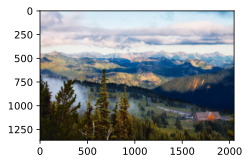

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('../d2l-zh-git-repo/img/rainier.jpg')
d2l.plt.imshow(content_img);

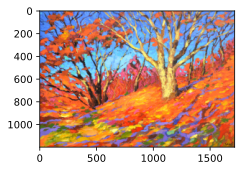

In [6]:
style_img = d2l.Image.open('../d2l-zh-git-repo/img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

In [7]:
# 这里两个函数就是对进来的图像进行imageNet上面那种预处理，然后再把预处理过后的，给弄回原始的样子
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [8]:
# 这里用了VGG19来进行特征的抽取，听说VGG19抽取特征还是挺不错的？
pretrained_net = torchvision.models.vgg19(pretrained=True)

/public/home/jxwang/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/public/home/jxwang/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /public/home/jxwang/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [07:20<00:00, 1.30MB/s] 


In [10]:
# 这里定义的是样式层和内容层
# 我们一般认为，最下面靠近输入的层，是越接近局部的特征的，越往上，是越全局的
# 所以这里内容层我们允许存在一定的差异，只要大局差不多就行，所以内容层在25
# 样式层我们想比较全面的学习到样式，设置在了很多地方
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [12]:
# 因为并不是使用CNN来真正的做图像分类，那这里的CNN我们只需要使用我们定义过的层之前的所有网络就好了
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [13]:
# 因为我们其实是要看每一层的输出结果的，所以我们这里要进行逐层的遍历去取得输出
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [15]:
# 这两个函数就是抽取出内容和风格
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

接下来我们来看看最关键的一点，如何定义损失函数

In [16]:
# 这里内容损失其实就很简单，用一个MSE就好
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

In [17]:
# 对于样式损失来说，我们其实通常会用通道间的匹配来做
# 其实这里有点难理解，就像抽象的画，你会发现一大片一大片都是一堆颜色，比如一大块都是绿色，一大块都是红色，另一边是黄色
# 那这个在通道间和通道内，统计分布其实是有特点的，会发现在通道内，方差肯定很小（因为一大片都是同样的颜色）
# 但是通道间方差会挺大的，因为不同颜色直接变，也没啥过度颜色
# 整体思路大概就是这样

# 这里我们计算一个gramm矩阵（也就是协方差）
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [18]:
# 用上面的gram矩阵来评估样式损失
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [19]:
# 这是一个通常用在降噪的算法
# 也就是让一个像素和上下左右的像素别差太多
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [21]:
# 不同loss的权重
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [22]:
# 这里其实就是人造了一个nn.module，用来随机生成图片
# 然后我们把图片的内容塞进这个module的weight里面，这样我们就可以训练这个weights了
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [23]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    # 这里是为了加快训练，我们用内容图片直接来初始化
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [24]:
# 训练这里就没啥区别了
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

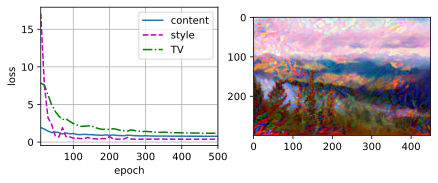

In [25]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

上面因为是一个很简单的例子，所以我们训练的其实是一个很小的图片，当要训练大图片的时候，如果说直接去训练这么大的，那估计是很慢

所以可以先像这里一样训练一个小一点的样本，然后再扔给大样本训练时当作初始化的值，这样可以训练更快